In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:04<00:00, 252MB/s]
100% 1.06G/1.06G [00:04<00:00, 266MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [6]:
conv_base = VGG16(
    weights='imagenet', #imagenet dataset trained weights
    include_top = False, #means we are removing fully connected layer part that is top
    input_shape=(150,150,3) #we can specify any input shape
)

58889256/58889256 [==============================] - 1s 0us/step


In [7]:
conv_base.summary()
#we have last layer pooling not having dense layer in this

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [8]:
model = Sequential()

model.add(conv_base)  #we add convo layer of vgg then our dense layer after
#flattening it
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
#now we need to freeze the vgg layers


conv_base.trainable = False

In [12]:
model.summary() #now trainable params reduces

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [13]:
#creating generators

train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [14]:
# Normalizing for making training fast
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [15]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 77s 103ms/step - loss: 0.2707 - accuracy: 0.8878 - val_loss: 0.2129 - val_accuracy: 0.9100
Epoch 2/10
625/625 [==============================] - 55s 88ms/step - loss: 0.1885 - accuracy: 0.9220 - val_loss: 0.2120 - val_accuracy: 0.9122
Epoch 3/10
625/625 [==============================] - 65s 103ms/step - loss: 0.1611 - accuracy: 0.9322 - val_loss: 0.2220 - val_accuracy: 0.9112
Epoch 4/10
625/625 [==============================] - 65s 104ms/step - loss: 0.1360 - accuracy: 0.9448 - val_loss: 0.2288 - val_accuracy: 0.9148
Epoch 5/10
625/625 [==============================] - 66s 106ms/step - loss: 0.1157 - accuracy: 0.9539 - val_loss: 0.2379 - val_accuracy: 0.9128
Epoch 6/10
625/625 [==============================] - 55s 88ms/step - loss: 0.0889 - accuracy: 0.9659 - val_loss: 0.2752 - val_accuracy: 0.9044
Epoch 7/10
625/625 [==============================] - 56s 88ms/step - loss: 0.0687 - accuracy: 0.9739 - val_loss: 0.2795 - val_accur

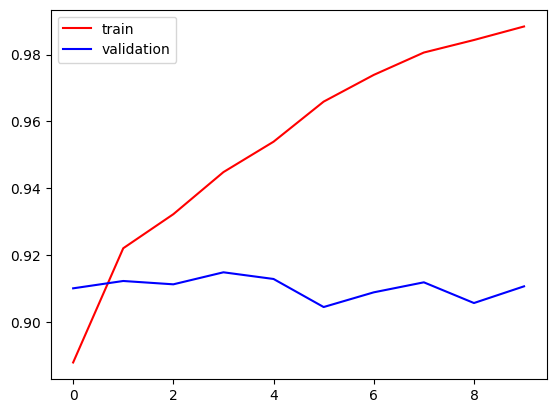

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

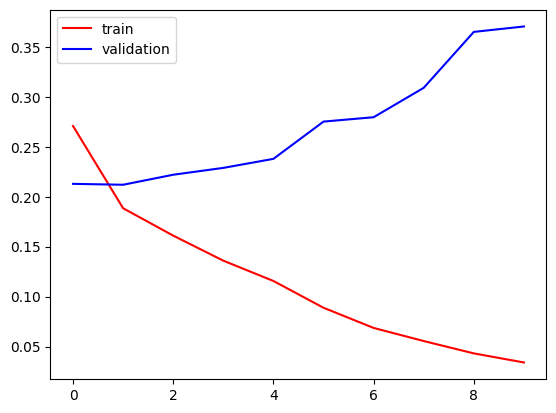

In [18]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [19]:
#model is overfitting as a lot of gap between training and validation error